In [1]:
import fsspec

fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True, use_ssl=False) # For now SSL false is solving my cert issues **shrug**
fs_write = fsspec.filesystem('') # For now we are writing to local disk

In [19]:
input_bucket = 'nextgen-dmac-cloud-ingest'
input_key = 'nos/dbofs/nos.dbofs.fields.f001.20240207.t00z.nc.zarr'

In [20]:
import re

model_date, model_hour = re.search(r'(\d{8}).t(\d{2})', input_key).groups()
model_date, model_hour

('20240207', '00')

In [23]:

dbofs_model_run_files = fs_read.glob(f's3://{input_bucket}/nos/dbofs/nos.dbofs.fields.f[0-9][0-9][0-9].{model_date}.t{model_hour}z.nc.zarr')
dbofs_model_run_files = sorted(['s3://'+f for f in dbofs_model_run_files])
dbofs_model_run_files

['s3://nextgen-dmac-cloud-ingest/nos/dbofs/nos.dbofs.fields.f001.20240207.t00z.nc.zarr',
 's3://nextgen-dmac-cloud-ingest/nos/dbofs/nos.dbofs.fields.f002.20240207.t00z.nc.zarr',
 's3://nextgen-dmac-cloud-ingest/nos/dbofs/nos.dbofs.fields.f003.20240207.t00z.nc.zarr',
 's3://nextgen-dmac-cloud-ingest/nos/dbofs/nos.dbofs.fields.f004.20240207.t00z.nc.zarr',
 's3://nextgen-dmac-cloud-ingest/nos/dbofs/nos.dbofs.fields.f005.20240207.t00z.nc.zarr',
 's3://nextgen-dmac-cloud-ingest/nos/dbofs/nos.dbofs.fields.f006.20240207.t00z.nc.zarr',
 's3://nextgen-dmac-cloud-ingest/nos/dbofs/nos.dbofs.fields.f007.20240207.t00z.nc.zarr',
 's3://nextgen-dmac-cloud-ingest/nos/dbofs/nos.dbofs.fields.f008.20240207.t00z.nc.zarr',
 's3://nextgen-dmac-cloud-ingest/nos/dbofs/nos.dbofs.fields.f009.20240207.t00z.nc.zarr',
 's3://nextgen-dmac-cloud-ingest/nos/dbofs/nos.dbofs.fields.f010.20240207.t00z.nc.zarr',
 's3://nextgen-dmac-cloud-ingest/nos/dbofs/nos.dbofs.fields.f011.20240207.t00z.nc.zarr',
 's3://nextgen-dmac-c

In [27]:
from kerchunk.combine import MultiZarrToZarr
import ujson

mzz = MultiZarrToZarr(
    dbofs_model_run_files,
    remote_protocol="s3",
    remote_options={"anon": True, "use_ssl": False},
    concat_dims=["ocean_time"],
    identical_dims=[
        "eta_rho",
        "xi_rho",
        "s_rho",
        "eta_psi",
        "xi_psi",
        "s_w",
        "eta_u",
        "xi_u",
        "eta_v",
        "xi_v",
        "lat_rho",
        "lat_psi",
        "lat_u",
        "lat_v",
        "lon_rho",
        "lon_psi",
        "lon_u",
        "lon_v",
        "mask_rho",
        "mask_psi",
        "mask_u",
        "mask_v",
    ],
)

d = mzz.translate()

outname = f"nos.dbofs.fields.{model_date}.t{model_hour}z.zarr"
with fs_write.open(outname, "wb") as f:
    f.write(ujson.dumps(d).encode())
    print(f"Successfully wrote kerchunked nos collection to disk: {outname}")

Successfully wrote kerchunked nos collection to disk: nos.dbofs.fields.20240207.t00z.zarr


In [28]:
import xarray as xr

# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo='nos.dbofs.fields.20240207.t00z.zarr', remote_protocol='s3', remote_options={'anon':True, 'use_ssl': False})
m = fs.get_mapper("") 

ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={'ocean_time':1, 'forecast_reference_time': 1})
ds

<xarray.Dataset>
Dimensions:        (ocean_time: 48, tracer: 2, s_rho: 10, s_w: 11, boundary: 4,
                    eta_rho: 732, xi_rho: 119, eta_psi: 731, xi_psi: 118,
                    eta_u: 732, xi_u: 118, eta_v: 731, xi_v: 119)
Coordinates:
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2024-02-07T01:00:00 ... 2024-0...
  * s_rho          (s_rho) float64 -0.95 -0.85 -0.75 -0.65 ... -0.25 -0.15 -0.05
  * s_w            (s_w) float64 -1.0 -0.9 -0.8 -0.7 -0.6 ... -0.3 -0.2 -0.1 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/79)
    Akk_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akp_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akt_bak        (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    Akv_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_r           (ocean_time, s_rho) float64 dask.array<chunksize=(1, 10), meta=np.ndarray>
    Cs_w           (ocean_time, s_w) float64 dask.array<chunksize=(1, 11), meta=np.ndarray>
    ...             ...
    theta_s        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    u              (ocean_time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(1, 10, 732, 118), meta=np.ndarray>
    v              (ocean_time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(1, 10, 731, 119), meta=np.ndarray>
    w              (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 6, 732, 119), meta=np.ndarray>
    xl             (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    zeta           (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 732, 119), meta=np.ndarray>
Attributes: (12/33)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AN...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    C...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_ra...
    bry_file_01:       nos.dbofs.obc.20240207.t00z.nc
    ...                ...
    svn_url:           
    tide_file:         nos.dbofs.roms.tides.nc
    tiling:            008x016
    title:             dbofs forecast RUN in operational mode
    type:              ROMS/TOMS history file
    var_info:          varinfo.yaml

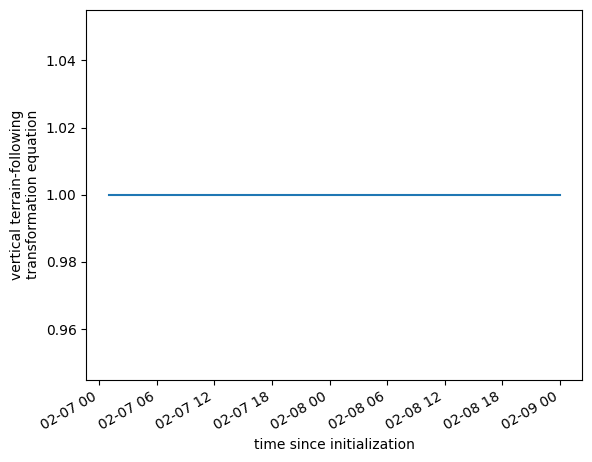

In [29]:
ds.Vtransform.plot()